### The function of this project will be to investigate the sales treds of the top five products in 2021 for North American branches of this bike manufacturing company

### Look at sales trends/seasonality to identify how best to market the product to maximise sales

### Look at our customer base during this COVID era

### Conduct forecasting for the new year, 2022 

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import seaborn as sns

# Connection to the database

db_user = "root"
db_password = "Janushan-123"
db_host = "localhost"  # e.g., 'localhost' or IP address
db_name = "attrition_employee"

engine = create_engine(
    f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}"
)

query = '''select sales_with_fk.*, product_with_pk.standard_cost
            from sales_with_fk
            JOIN product_with_pk
            on sales_with_fk.product_key = product_with_pk.product_key
            where sales_territory_region in ('Central',"Northwest","Southwest","Southeast","Northeast") 
            and sales_with_fk.standard_order_date between "2021-01-01" and "2022-01-01"'''


df = pd.read_sql(query, engine)

In [2]:
df["standard_order_date"] = pd.to_datetime(df["standard_order_date"])

print(df["standard_order_date"].min())
print(df["standard_order_date"].max())
print(df["sales_territory_region"].unique())


2021-01-01 00:00:00
2022-01-01 00:00:00
['Southwest' 'Northwest' 'Northeast' 'Central' 'Southeast']


In [3]:
data_filt = df.copy()
data_filt

,ind_sale_id,product_key,customer_key,order_date,sales_territory_region,sales_order_number,sales_order_line_number,order_quantity,unit_price,freight,standard_order_date,standard_cost
0,46995,335,15517,2021-01-01,Southwest,SO48811,1,1,782.99,20,2021-01-01,486.7066
1,46996,333,15497,2021-01-02,Southwest,SO48818,1,1,782.99,20,2021-01-02,486.7066
2,46997,360,26729,2021-01-03,Northwest,SO48827,1,1,2049.10,51,2021-01-03,1105.8100
3,46998,352,26695,2021-01-04,Southwest,SO48834,1,1,2071.42,52,2021-01-04,1117.8559
4,46999,325,15489,2021-01-06,Northwest,SO48843,1,1,782.99,20,2021-01-06,486.7066
...,...,...,...,...,...,...,...,...,...,...,...,...
17189,76931,479,29201,2022-01-01,Southwest,SO61363,3,1,8.99,0,2022-01-01,3.3623
17190,76932,562,24684,2022-01-01,Southwest,SO61364,1,1,2384.07,60,2022-01-01,1481.9379
17191,76933,225,24684,2022-01-01,Southwest,SO61364,2,1,8.99,0,2022-01-01,6.9223
17192,76934,582,20683,2022-01-01,Southwest,SO61365,1,1,1700.99,43,2022-01-01,1082.5100


In [4]:
data_filt["unit_price"] = data_filt["unit_price"].round(2)
round(data_filt["unit_price"].sum(), 2)

5707580.04

In [5]:
data_filt["line_total_sales"] = data_filt["unit_price"] * data_filt["order_quantity"]
data_filt["cost_of_product"] = round(
    data_filt["standard_cost"] * data_filt["order_quantity"], 2
)
data_filt["line_margin"] = round(
    data_filt["line_total_sales"] - data_filt["cost_of_product"], 2
)


## Visualisation of 2021 sales

<Axes: xlabel='standard_order_date', ylabel='line_margin'>

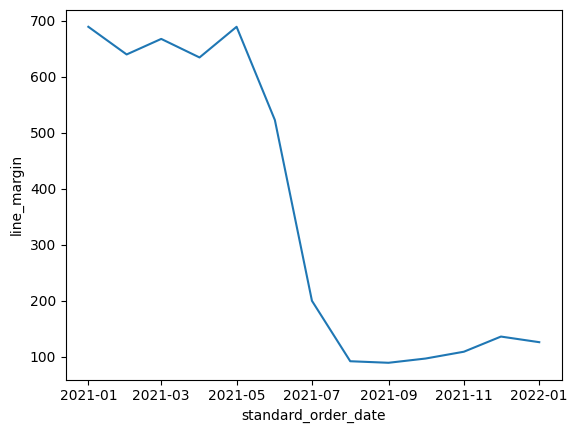

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

aggregated_data = (
    data_filt.groupby(data_filt["standard_order_date"].dt.to_period("M"))[
        ["line_margin"]
    ]
    .mean()
    .reset_index()
)
aggregated_data["standard_order_date"] = aggregated_data[
    "standard_order_date"
].dt.start_time

sns.lineplot(x="standard_order_date", y="line_margin", data=aggregated_data)


# max, min point, make dates horizontal, make it nicer to look at, price on y axis should have comma and doller sign

In [7]:
# line total sales = unit price * quantity added up
# cost of product = unit cost * quantity added up
# Line margin = line total sales - cost of product

# Total margin = sum of line margin
# Total sales = sum of line total sales
# Total cost = sum of cost of product

# Margin % = Total margin / Total sales
# Cost % = Total cost / Total sales

# metric --> average order value, count of orders, growth rates of these things,
# customer retention rate, customer acquisition rate, customer churn rate, customer lifetime value, customer acquisition cost

## Work out top 5 global products pre-2022

In [2]:
query = '''select sales_with_fk.*,
        product_with_pk.standard_cost,
        product_with_pk.product_name,
        product_with_pk.product_subcategory
            from sales_with_fk
            JOIN product_with_pk
            on sales_with_fk.product_key = product_with_pk.product_key
            where sales_with_fk.standard_order_date < "2023-01-01"'''

global_sales = pd.read_sql(query, engine)

# Filling Freight values


def fill_freight(x):
    if x <= 5:
        return 0.12
    if x <= 30:
        return 1
    if x <= 120:
        return 3
    if x <= 500:
        return 13
    if x <= 700:
        return 17
    if x <= 1000:
        return 25
    if x <= 1200:
        return 30
    if x <= 1700:
        return 40
    if x <= 2000:
        return 50
    if x <= 2300:
        return 57
    if x <= 3300:
        return 84
    else:
        return 90


global_sales["freight_cost"] = global_sales["unit_price"].apply(fill_freight)

global_sales["line_total_sales"] = (
    global_sales["unit_price"] * global_sales["order_quantity"]
)
global_sales["cost_of_product"] = round(
    global_sales["standard_cost"] * global_sales["order_quantity"], 2
)
global_sales["line_margin"] = round(
    global_sales["line_total_sales"]
    - global_sales["cost_of_product"]
    - global_sales["freight_cost"],
    2,
)

global_sales["standard_order_date"] = pd.to_datetime(
    global_sales["standard_order_date"]
)
global_sales["Year"] = global_sales["standard_order_date"].dt.year
global_sales["Month"] = global_sales["standard_order_date"].dt.month
global_sales["Quarter"] = global_sales["standard_order_date"].dt.quarter

global_sales["YearMonth"] = (
    global_sales["Year"].astype(str) + "-" + global_sales["Month"].astype(str) + "-01"
)

In [9]:
global_sales

,ind_sale_id,product_key,customer_key,order_date,sales_territory_region,sales_order_number,sales_order_line_number,order_quantity,unit_price,freight,...,product_name,product_subcategory,freight_cost,line_total_sales,cost_of_product,line_margin,Year,Month,Quarter,YearMonth
0,1,539,15146,2022-01-01,New Zealand,SO61315,1,1,24.99,NaN,...,ML Road Tire,tires and tubes,1.00,24.99,9.35,14.64,2022,1,1,2022-1-01
1,2,529,15146,2022-01-01,New Zealand,SO61315,2,1,3.99,NaN,...,Road Tire Tube,tires and tubes,0.12,3.99,1.49,2.38,2022,1,1,2022-1-01
2,3,222,15146,2022-01-01,New Zealand,SO61315,3,1,34.99,NaN,...,"Sport-100 Helmet, Blue",helmets,3.00,34.99,13.09,18.90,2022,1,1,2022-1-01
3,4,490,15146,2022-01-01,New Zealand,SO61315,4,1,53.99,NaN,...,"Short-Sleeve Classic Jersey, L",jerseys,3.00,53.99,41.57,9.42,2022,1,1,2022-1-01
4,5,225,15146,2022-01-01,New Zealand,SO61315,5,1,8.99,NaN,...,AWC Logo Cap,caps,1.00,8.99,6.92,1.07,2022,1,1,2022-1-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88471,88472,487,13753,2022-07-28,Southwest,SO75110,2,1,54.99,1.0,...,Hydration Pack - 70 oz.,hydration packs,3.00,54.99,20.57,31.42,2022,7,3,2022-7-01
88472,88473,484,13753,2022-07-28,Southwest,SO75110,3,1,7.95,0.0,...,Bike Wash - Dissolver,cleaners,1.00,7.95,2.97,3.98,2022,7,3,2022-7-01
88473,88474,528,11981,2022-07-28,Northwest,SO75119,1,1,4.99,0.0,...,Mountain Tire Tube,tires and tubes,0.12,4.99,1.87,3.00,2022,7,3,2022-7-01
88474,88475,537,11981,2022-07-28,Northwest,SO75119,2,1,35.00,1.0,...,HL Mountain Tire,tires and tubes,3.00,35.00,13.09,18.91,2022,7,3,2022-7-01


In [10]:
topmargin_m = global_sales.groupby(global_sales["product_name"])[["line_margin"]].mean()
topmargin_m = topmargin_m.sort_values(by="line_margin", ascending=False).head(5)

topmargin = global_sales.groupby(global_sales["product_name"])[["line_margin"]].sum()
topmargin = topmargin.sort_values(by="line_margin", ascending=False).head(60)

topcost = global_sales.groupby(global_sales["product_name"])[["cost_of_product"]].sum()
topcost = topcost.sort_values(by="cost_of_product", ascending=False).head(5)

topsales = global_sales.groupby(global_sales["product_name"])[
    ["line_total_sales"]
].sum()
topsales = topsales.sort_values(by="line_total_sales", ascending=False).head(5)
topsales = topsales.reset_index()

mostsells = global_sales.groupby(global_sales["product_name"])[["order_quantity"]].sum()
mostsells = mostsells.sort_values(by="order_quantity", ascending=False).head(5)

topmargin, topmargin_m, topcost, topsales, mostsells

(                           line_margin
 product_name                          
 Mountain-200 Black, 46       863553.54
 Mountain-200 Black, 42       827691.87
 Mountain-200 Silver, 38      805369.95
 Mountain-200 Black, 38       798133.95
 Mountain-200 Silver, 46      794854.34
 Mountain-200 Silver, 42      780435.57
 Road-150 Red, 48             621614.56
 Road-150 Red, 62             607127.78
 Road-150 Red, 52             545229.72
 Road-150 Red, 56             525475.02
 Road-150 Red, 44             503086.36
 Road-250 Black, 52           322457.80
 Road-250 Red, 58             320043.04
 Road-250 Black, 48           306382.80
 Road-250 Black, 58           279844.88
 Road-250 Black, 44           274222.92
 Touring-1000 Blue, 46        220895.10
 Touring-1000 Yellow, 46      211077.54
 Road-350-W Yellow, 40        208063.68
 Road-350-W Yellow, 42        206926.72
 Touring-1000 Yellow, 54      205350.63
 Touring-1000 Blue, 54        202078.11
 Road-350-W Yellow, 48        193283.20


In [11]:
topmargin_m_sub = global_sales.groupby(global_sales["product_subcategory"])[
    ["line_margin"]
].mean()
topmargin_m_sub = topmargin_m_sub.sort_values(by="line_margin", ascending=False).head(5)

topmargin_sub = global_sales.groupby(global_sales["product_subcategory"])[
    ["line_margin"]
].sum()
topmargin_sub = topmargin_sub.sort_values(by="line_margin", ascending=False).head(5)

topcost_sub = global_sales.groupby(global_sales["product_subcategory"])[
    ["cost_of_product"]
].sum()
topcost_sub = topcost_sub.sort_values(by="cost_of_product", ascending=False).head(5)

topsales_sub = global_sales.groupby(global_sales["product_subcategory"])[
    ["line_total_sales"]
].sum()
topsales_sub = topsales_sub.sort_values(by="line_total_sales", ascending=False).head(5)
topsales_sub = topsales_sub.reset_index()

mostsells_sub = global_sales.groupby(global_sales["product_subcategory"])[
    ["order_quantity"]
].sum()
mostsells_sub = mostsells_sub.sort_values(by="order_quantity", ascending=False).head(5)

topmargin_sub, topmargin_m_sub, topcost_sub, topsales_sub, mostsells_sub

(                     line_margin
 product_subcategory             
 road bikes            7002261.80
 mountain bikes        5984137.83
 touring bikes         1983794.03
 tires and tubes        207135.96
 helmets                177584.40,
                      line_margin
 product_subcategory             
 mountain bikes        840.823076
 road bikes            620.163121
 touring bikes         614.177718
 bike stands            86.530000
 bike racks             72.120000,
                      cost_of_product
 product_subcategory                 
 road bikes               12301622.25
 mountain bikes            7708178.02
 touring bikes             3589010.13
 jerseys                    198149.99
 tires and tubes            135364.28,
   product_subcategory  line_total_sales
 0          road bikes       19865489.05
 1      mountain bikes       14109009.85
 2       touring bikes        5773826.16
 3     tires and tubes         361806.96
 4             helmets         328766.04,
        

In [12]:
top_prods_long = topmargin.index.tolist()
top_prods_long_data = global_sales[global_sales["product_name"].isin(top_prods_long)]
years = [2019, 2020, 2021, 2022]

top_prods_long_slice = top_prods_long_data.groupby(["product_name", "Year"])[
    ["order_quantity"]
].sum()
top_prods_long_slice = top_prods_long_slice.unstack(level="Year", fill_value=0)

top_prods_long_slice.columns = top_prods_long_slice.columns.droplevel().astype(int)

top_prods_long_slice = top_prods_long_slice.reindex(columns=years, fill_value=0)
top_prods_long_slice

## For road 150, there are sales in 2019 and 2020
## For road 250, there are sales in 2020 and 2021

## I'm thinking that they went from and older model to a newer model, and completely stopped selling the older model
## So we're going to have to concatenate all the differnet product models into one big one, and average by the number of products in that category
## Or could be product subcategory

Year,2019,2020,2021,2022
product_name,,,,
Fender Set - Mountain,0,0,1291,2003
"Mountain-100 Black, 38",23,35,0,0
"Mountain-100 Black, 42",22,33,0,0
"Mountain-100 Black, 44",37,38,0,0
"Mountain-100 Black, 48",23,48,0,0
"Mountain-100 Silver, 38",40,36,0,0
"Mountain-100 Silver, 42",21,32,0,0
"Mountain-100 Silver, 44",30,28,0,0
"Mountain-100 Silver, 48",16,29,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200000.0, 400000.0)

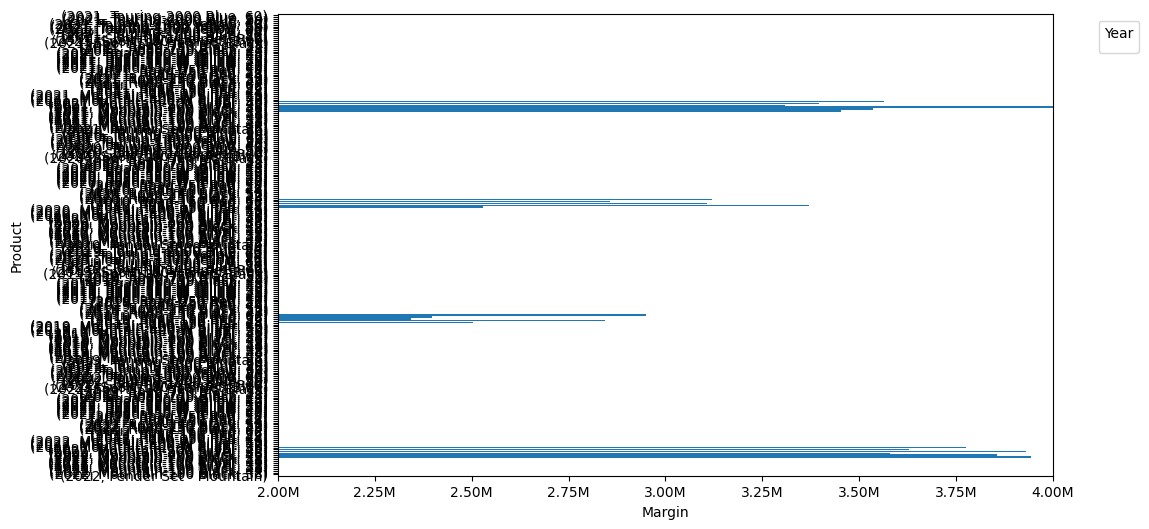

In [13]:
import matplotlib.ticker as mticker

top_prods = topmargin.index.tolist()
top_prods_data = global_sales[global_sales["product_name"].isin(top_prods)]

years = list(global_sales["Year"].unique())

topmargin_byYear = (
    top_prods_data.groupby(["product_name", "Year"])[["line_margin"]]
    .sum()
    .unstack(fill_value=0)
)
topmargin_byYear = topmargin_byYear["line_margin"].reindex(columns=years, fill_value=0)

plot = topmargin_byYear.unstack().plot(
    kind="barh", stacked=False, grid=False, width=0.8, figsize=(10, 6)
)

plot.set_xlabel("Margin")
plot.set_ylabel("Product")

plot.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x / 1e5:.2f}M"))

plot.legend(
    title="Year",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    # labels=[str(x) for x in topmargin_byYear.index.get_level_values(1).unique()]
)

plot.set_xlim(200000, 400000)


Text(0.5, 1.0, 'Top 5 Products by Total Sales')

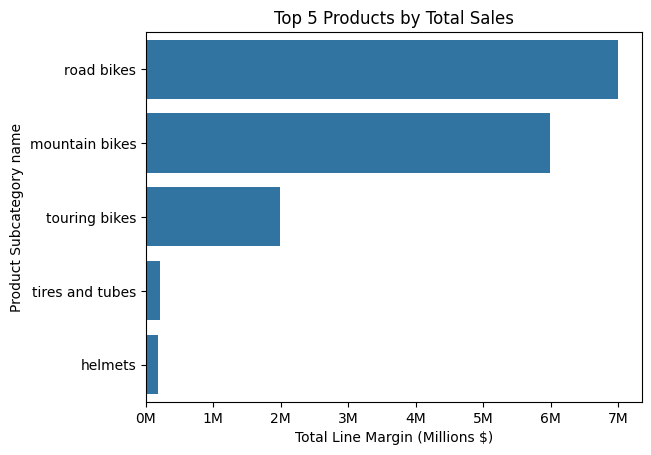

In [14]:
import matplotlib.ticker as mticker

filt_data = global_sales["Year"]

topmargin_sub = global_sales.groupby(global_sales["product_subcategory"])[
    ["line_margin"]
].sum()
topmargin_sub = topmargin_sub.sort_values(by="line_margin", ascending=False).head(5)

plot = sns.barplot(
    y="product_subcategory", x="line_margin", data=topmargin_sub, orient="h"
)

plot.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x / 1e6:.0f}M"))

plot.set_xlabel("Total Line Margin (Millions $)")
plot.set_ylabel("Product Subcategory name")
plot.set_title("Top 5 Products by Total Sales")


Text(0, 0.5, 'Product Subcategory')

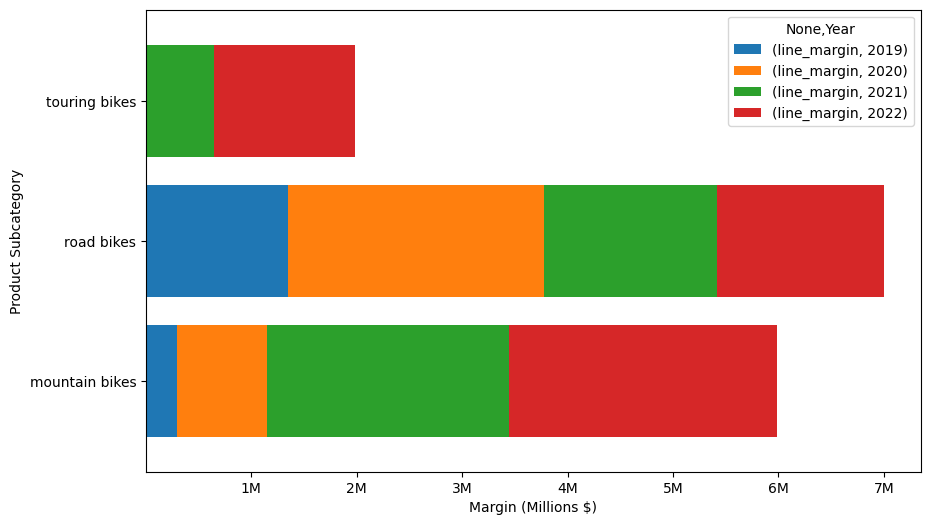

In [15]:
subproducts = ["road bikes", "mountain bikes", "touring bikes"]
subproduct_sales = global_sales[global_sales["product_subcategory"].isin(subproducts)]
subproduct_sales = (
    subproduct_sales.groupby(["product_subcategory", "Year"])[["line_margin"]]
    .sum()
    .unstack(fill_value=1)
)

plot = subproduct_sales.plot(
    kind="barh", stacked=True, grid=False, width=0.8, figsize=(10, 6)
)

plot.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x / 1e6:.0f}M"))
plt.xlabel("Margin (Millions $)")
plt.ylabel("Product Subcategory")

In [16]:
top_5 = (
    global_sales.groupby(global_sales["product_subcategory"])
    .agg({"line_margin": "sum", "cost_of_product": "sum", "order_quantity": "sum"})
    .reset_index()
)

scale_columns = ["line_margin", "cost_of_product"]

top_5[scale_columns] = round(
    top_5[scale_columns].div(top_5[scale_columns].sum(), axis=1) * 100, 1
)
top_5 = top_5.sort_values(by="line_margin", ascending=False).head(5)
top_5.rename(
    columns={
        "product_name": "Product Name",
        "line_margin": "Margin %",
        "cost_of_product": "Cost %",
        "order_quantity": "Order Quantity",
    },
    inplace=True,
)

top_5

,product_subcategory,Margin %,Cost %,Order Quantity
11,road bikes,44.5,50.6,11291
10,mountain bikes,38.0,31.7,7117
15,touring bikes,12.6,14.8,3230
14,tires and tubes,1.3,0.6,25334
7,helmets,1.1,0.5,9396


## Why did we choose Fourier analysis? The high accuracy and analysis of complex frequencies, we might expect turbulence in sales during the covid period, simple methods like seasonal decompostiion of time series may not be good enough. 

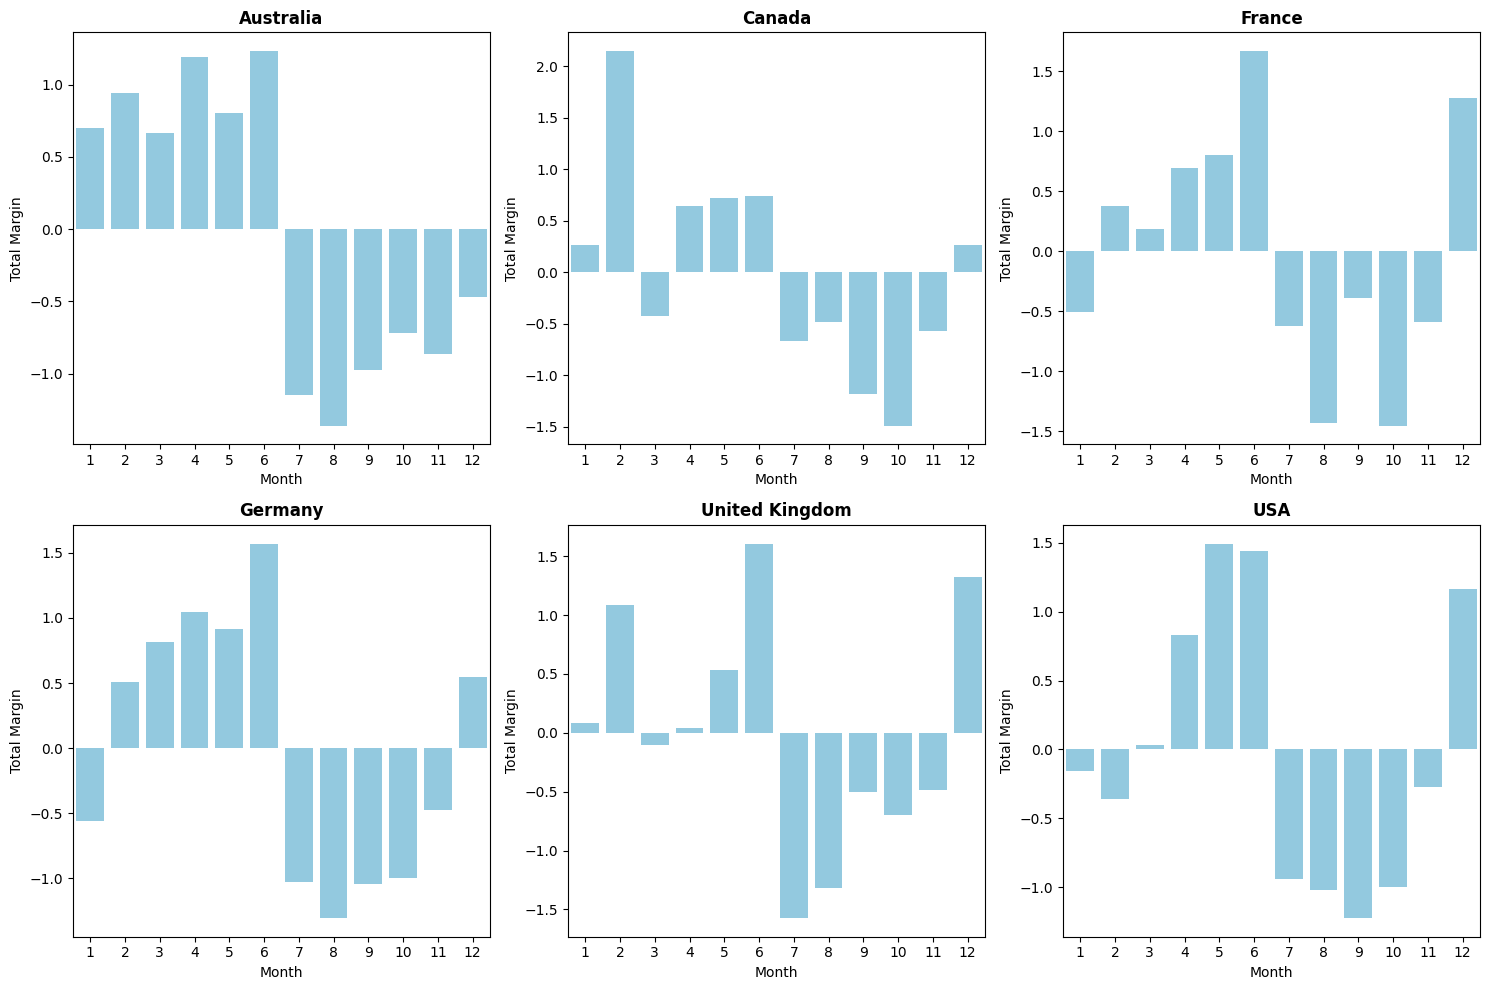

In [17]:
global_sales_concat = global_sales.copy()
global_sales_concat["sales_territory_region"] = global_sales_concat[
    "sales_territory_region"
].replace(["Central", "Northwest", "Southwest", "Southeast", "Northeast"], "USA")
global_sales_concat["sales_territory_region"] = global_sales_concat[
    "sales_territory_region"
].replace(["New Zealand"], "Australia")


regions = global_sales_concat["sales_territory_region"].unique().tolist()
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for idx, region in enumerate(regions):
    filt_data = global_sales_concat[
        global_sales_concat["sales_territory_region"] == region
    ]
    timeseries = (
        filt_data.groupby(filt_data["standard_order_date"].dt.month)["line_margin"]
        .sum()
        .reset_index()
    )
    timeseries["line_margin"] = (
        timeseries["line_margin"] - timeseries["line_margin"].mean()
    ) / timeseries["line_margin"].std()
    sns.barplot(
        x="standard_order_date",
        y="line_margin",
        data=timeseries,
        ax=axs[idx],
        color="skyblue",
    )
    axs[idx].set_title(region, weight="bold")
    axs[idx].set_xlabel("Month")
    axs[idx].set_ylabel("Total Margin")


# axs[len(regions)].axis('off')  # Hide the last subplot
plt.tight_layout()

## Show significant regression line with a rise in summer, dup in autumn, and rise in winter.

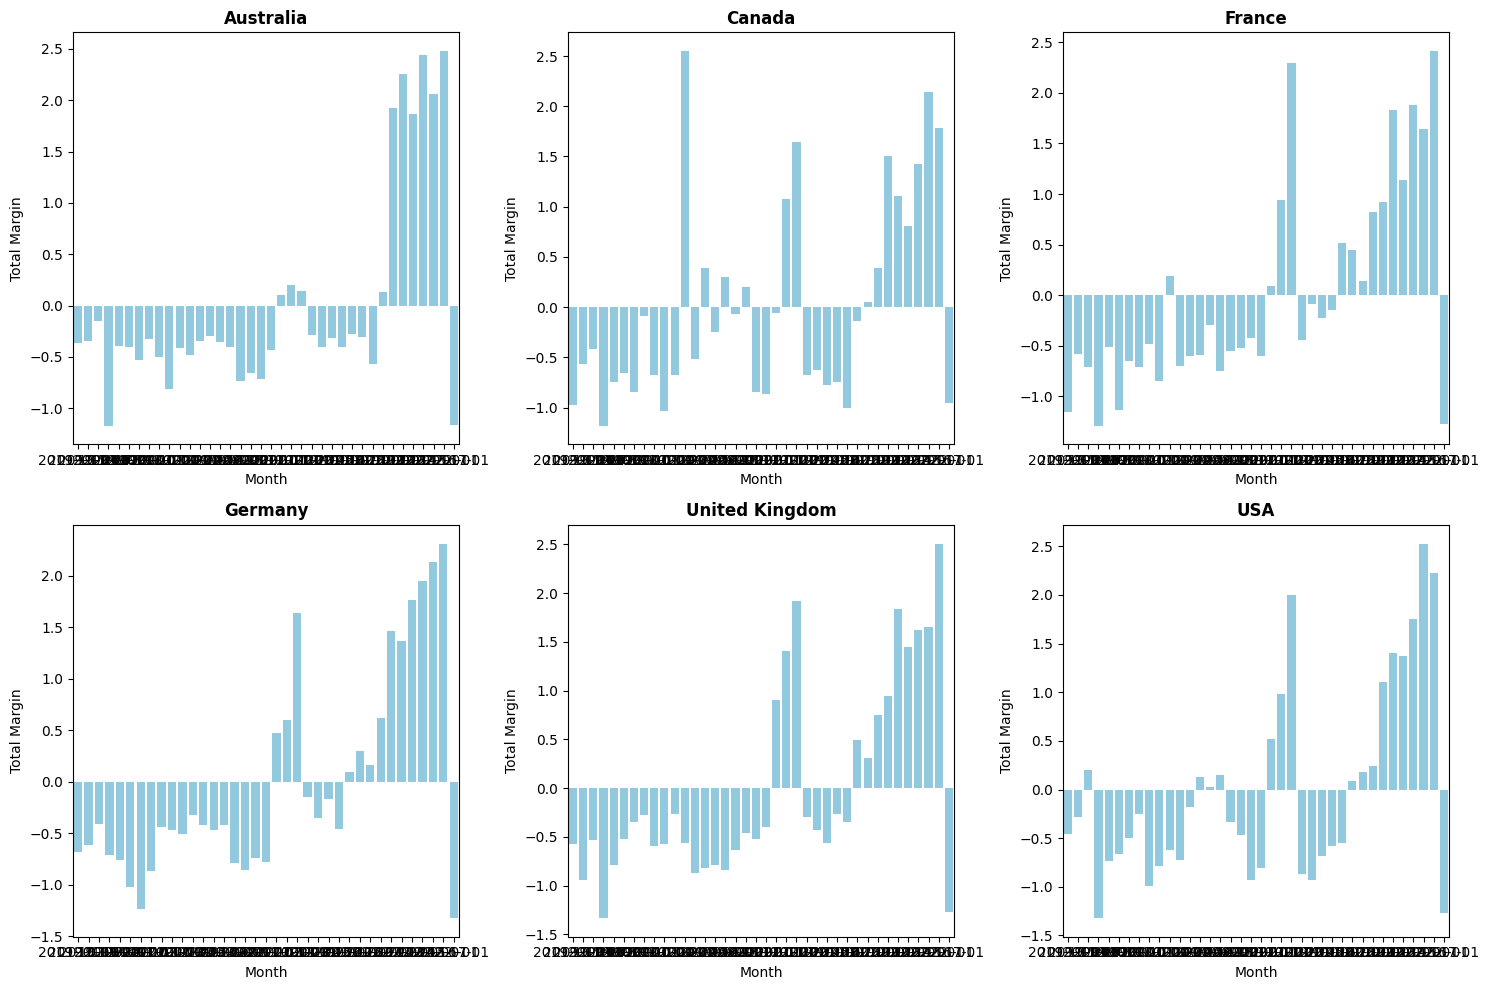

In [18]:
regions = global_sales_concat["sales_territory_region"].unique().tolist()
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for idx, region in enumerate(regions):
    filt_data = global_sales_concat[
        global_sales_concat["sales_territory_region"] == region
    ]
    timeseries = (
        filt_data.groupby(filt_data["YearMonth"])["line_margin"].sum().reset_index()
    )
    timeseries["line_margin"] = (
        timeseries["line_margin"] - timeseries["line_margin"].mean()
    ) / timeseries["line_margin"].std()
    sns.barplot(
        x="YearMonth", y="line_margin", data=timeseries, ax=axs[idx], color="skyblue"
    )
    axs[idx].set_title(region, weight="bold")
    axs[idx].set_xlabel("Month")
    axs[idx].set_ylabel("Total Margin")


# axs[len(regions)].axis('off')  # Hide the last subplot
plt.tight_layout()

## Show significant regression line with a rise in summer, dup in autumn, and rise in winter.

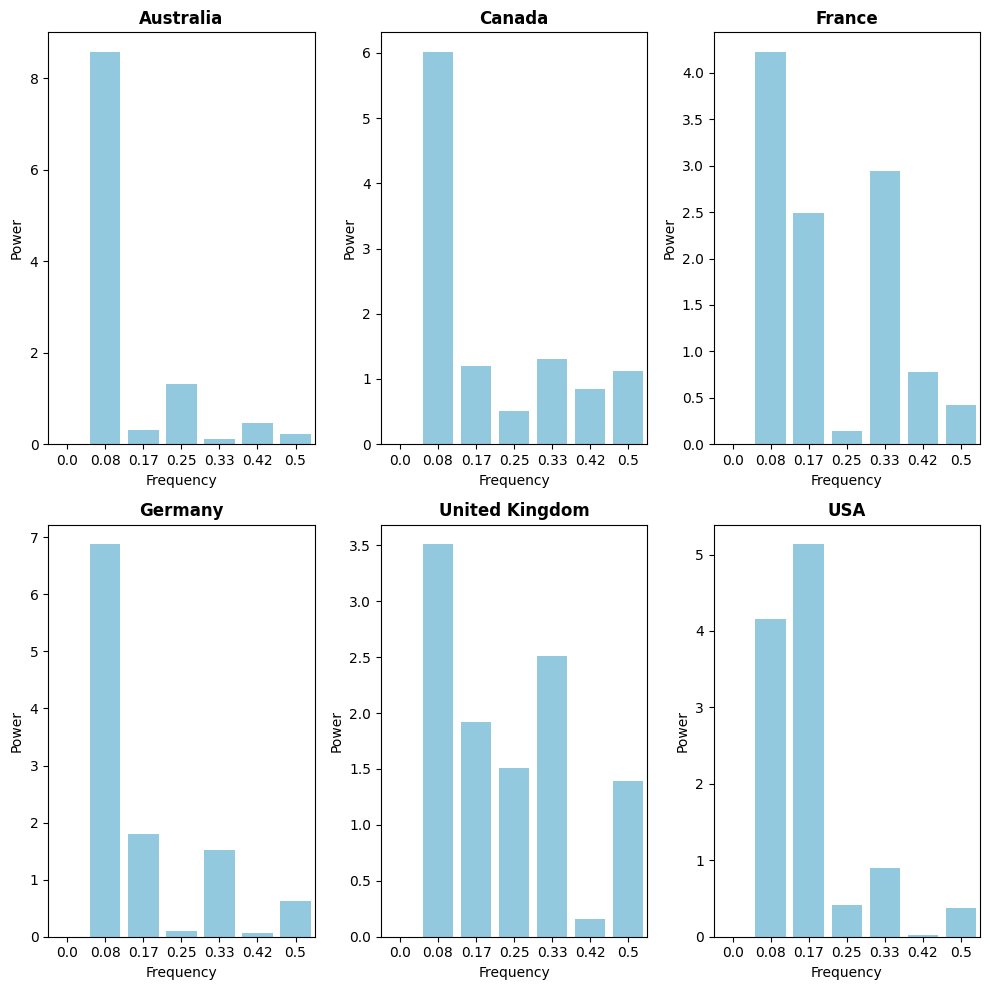

In [19]:
## Fourier analyis, split the data into countries and do a fourier analysis on the data, and see if there are any significant trends

from scipy.signal import periodogram
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()

for idx, region in enumerate(regions):
    filt_data = global_sales_concat[
        global_sales_concat["sales_territory_region"] == region
    ]
    timeseries = (
        filt_data.groupby(filt_data["standard_order_date"].dt.month)["line_margin"]
        .sum()
        .reset_index()
    )
    timeseries["line_margin"] = (
        timeseries["line_margin"] - timeseries["line_margin"].mean()
    ) / timeseries["line_margin"].std()

    freq, power = periodogram(timeseries["line_margin"], fs=1)
    freq = np.round(freq, 2)
    sns.barplot(x=freq, y=power, ax=axs[idx], color="skyblue")
    axs[idx].set_title(region, weight="bold")
    axs[idx].set_xlabel("Frequency")
    axs[idx].set_ylabel("Power")

# axs[len(regions)].axis('off')  # Hide the last subplot
plt.tight_layout()

### Don't aggreate over the months, retain the data, have to figure that out though


In [20]:
# According the chatGPT, the meaning of the peak at 0.08 is that there is a yearly cycle

# 0.08Hz is the number of cycles per second, so 0.08 cycles per second is 1 cycle per 12.5 seconds (1 second / 0.08 freq.), which is 1 cycle per 12.5 months

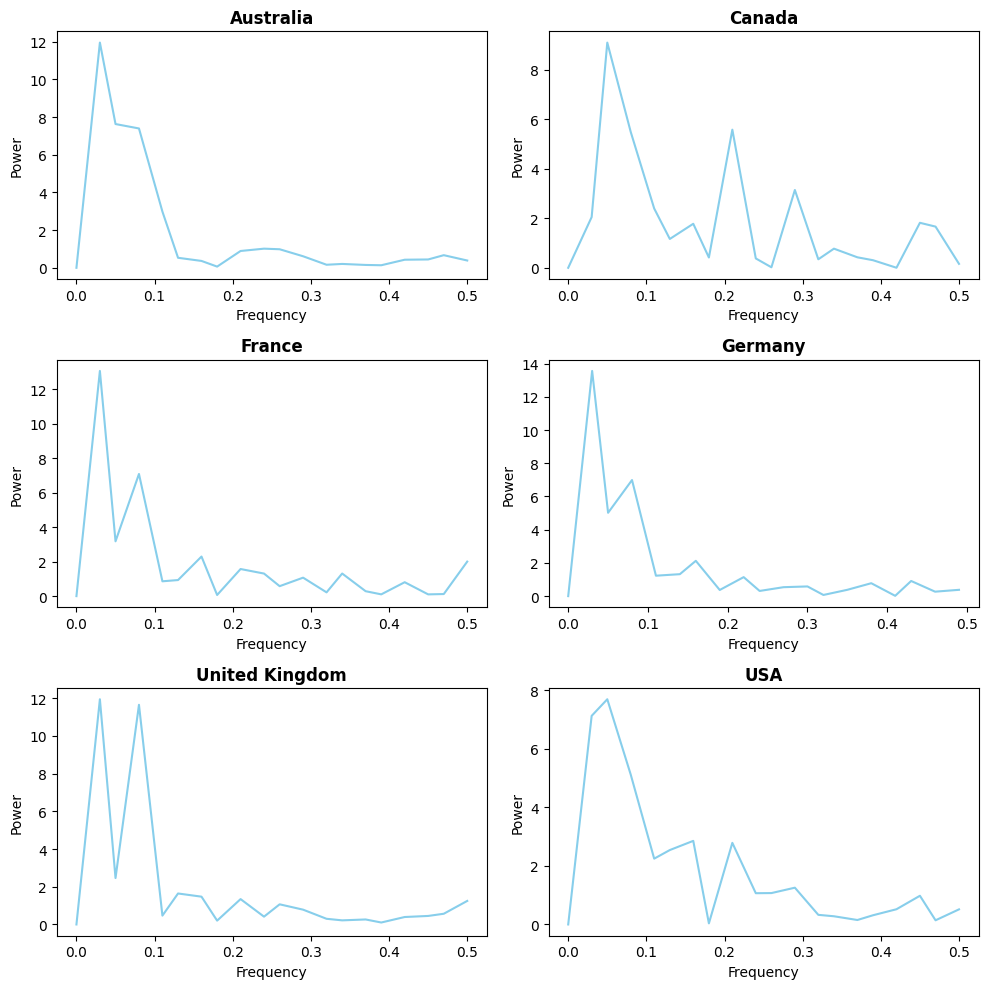

In [21]:
from scipy.signal import periodogram
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()

for idx, region in enumerate(regions):
    filt_data = global_sales_concat[
        global_sales_concat["sales_territory_region"] == region
    ]
    timeseries = (
        filt_data.groupby(filt_data["YearMonth"])["line_margin"].sum().reset_index()
    )
    timeseries["line_margin"] = (
        timeseries["line_margin"] - timeseries["line_margin"].mean()
    ) / timeseries["line_margin"].std()

    freq, power = periodogram(timeseries["line_margin"], fs=1)
    freq = np.round(freq, 2)
    sns.lineplot(x=freq, y=power, ax=axs[idx], color="skyblue")
    axs[idx].set_title(region, weight="bold")
    axs[idx].set_xlabel("Frequency")
    axs[idx].set_ylabel("Power")
    # axs[idx].set_xticks(np.arange(0, max(freq), 0.1))

# for ax in axs:
#     ax.tick_params(axis='x', rotation=45)

# axs[len(regions)].axis('off')  # Hide the last subplot
plt.tight_layout()

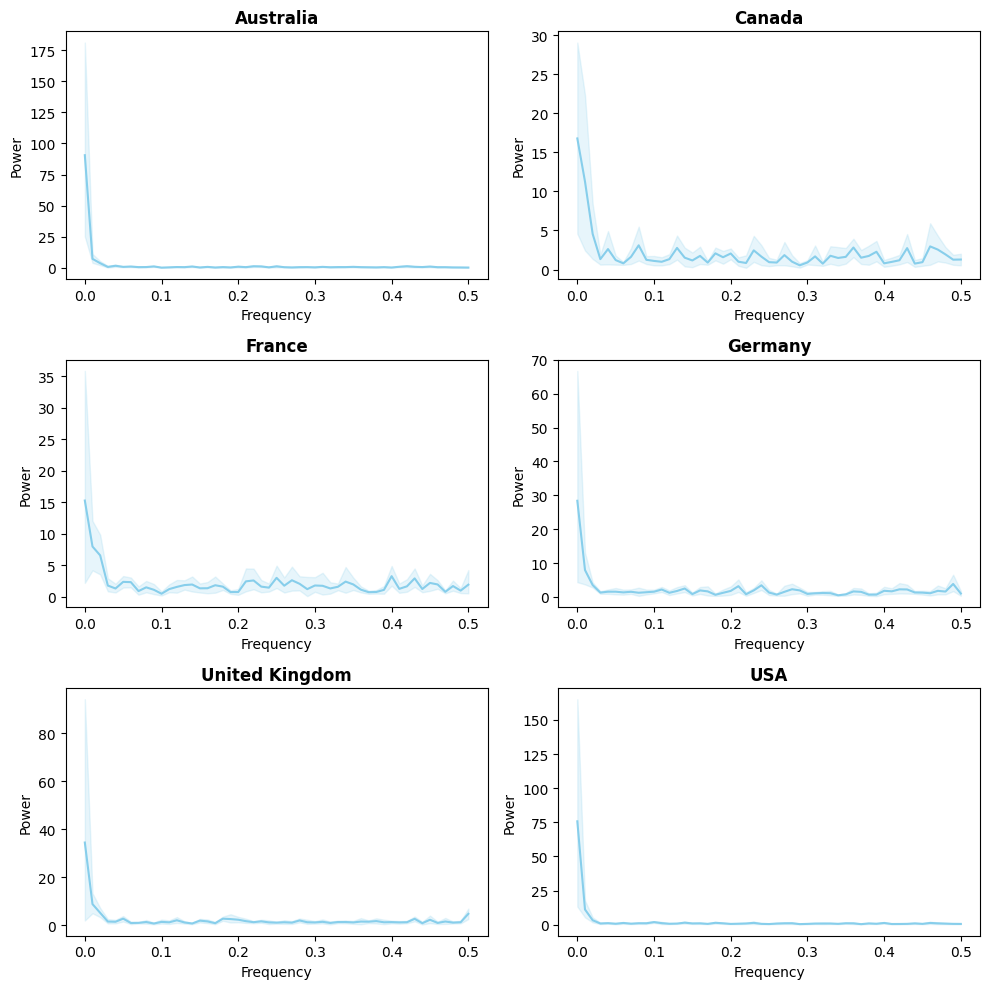

In [22]:
from scipy.signal import periodogram
import numpy as np

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()

for idx, region in enumerate(regions):
    filt_data = global_sales_concat[
        global_sales_concat["sales_territory_region"] == region
    ]
    timeseries = (
        filt_data.groupby(filt_data["standard_order_date"])["line_margin"]
        .sum()
        .reset_index()
    )
    timeseries["line_margin"] = (
        timeseries["line_margin"] - timeseries["line_margin"].mean()
    ) / timeseries["line_margin"].std()

    freq, power = periodogram(timeseries["line_margin"], fs=1)
    freq = np.round(freq, 2)
    sns.lineplot(x=freq, y=power, ax=axs[idx], color="skyblue")
    axs[idx].set_title(region, weight="bold")
    axs[idx].set_xlabel("Frequency")
    axs[idx].set_ylabel("Power")

# axs[len(regions)].axis('off')  # Hide the last subplot
plt.tight_layout()

In [23]:
## Before we do any analysis, we need to check for missing values to impute them
## no need for noise reduction as we are using a fourier analysis which is a frequency analysis,
## hence high frequency noise will not affect the analysis

UK_sales = global_sales_concat[
    global_sales_concat["sales_territory_region"] == "United Kingdom"
]
UK_sales = (
    UK_sales.groupby(UK_sales["standard_order_date"])["line_margin"].sum().reset_index()
)

# Missing data
UK_sales["gap"] = UK_sales["standard_order_date"].diff() > pd.Timedelta(days=1)
print(UK_sales.groupby(UK_sales["gap"]).count(), "\n", UK_sales.shape)
# UK_sales.drop("gap", axis=1, inplace=True)

# Inpute mussing data
UK_sales = UK_sales.set_index("standard_order_date").resample("D").asfreq()
UK_sales = UK_sales.interpolate(method="linear")
print("\n", UK_sales.shape)

# With times series its common to denoise and impute data, here we don't need denoising as we're doing a fourier analysis
# Secondly, there is a lot of missing data and too much imputing could distort trends

impute_percs = []

countries_data = global_sales_concat["sales_territory_region"].unique().tolist()

for i in range(len(countries_data)):
    dat = global_sales_concat[
        global_sales_concat["sales_territory_region"] == countries_data[i]
    ].reset_index()
    shape1 = dat.shape[0]

    dat = dat.set_index("standard_order_date").resample("D").asfreq()
    dat = dat.interpolate(method="linear")
    shape2 = dat.shape[0]

    impute_percs.append(((shape1 - shape2) / shape1) * 100)


       standard_order_date  line_margin
gap                                    
False                  598          598
True                   170          170 
 (768, 3)

 (1125, 2)


C:\Users\janus\AppData\Local\Temp\ipykernel_6956\75458259.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  UK_sales = UK_sales.interpolate(method="linear")


ValueError: cannot reindex on an axis with duplicate labels

In [25]:
timeseries_cut = UK_sales["line_margin"].values
# standardise timeseries
timeseries_cut = (timeseries_cut - np.mean(timeseries_cut)) / np.std(timeseries_cut)

nboot = 10000


def manual_fft(x):
    freq, power = periodogram(x, fs=1.0)
    return power


def bootstrap(x, nboot, funct):
    freq, power = periodogram(x, fs=1.0)

    null_data = np.zeros((nboot, power.shape[0]))

    for i in range(nboot):
        null_data[i] = funct(np.random.permutation(x))

    return null_data


null_data = bootstrap(timeseries_cut, nboot, manual_fft)
null_data_av = np.mean(null_data, axis=0)
null_data

array([[1.00974196e-31, 6.61718628e+00, 1.03914945e+00, ...,
        2.51699577e+00, 2.23523853e+00, 1.60835207e+00],
       [8.48463729e-32, 8.83702709e-02, 1.57277230e+00, ...,
        9.94119261e-01, 2.77918980e+00, 1.10068907e+00],
       [4.03896783e-31, 1.11991180e+01, 9.10558421e+00, ...,
        2.25132579e+00, 9.96474500e-01, 4.85216727e+00],
       ...,
       [3.39385492e-31, 3.47967160e+00, 7.85645985e+00, ...,
        4.49472383e-01, 3.11626934e+00, 1.64310977e-01],
       [2.80483877e-31, 1.47032573e+00, 7.53299755e-01, ...,
        3.51024459e+00, 1.64652710e+00, 2.50352569e+00],
       [3.39385492e-31, 3.00826095e+00, 7.16208433e-01, ...,
        7.21961938e-01, 6.32887697e+00, 2.39583889e+00]])

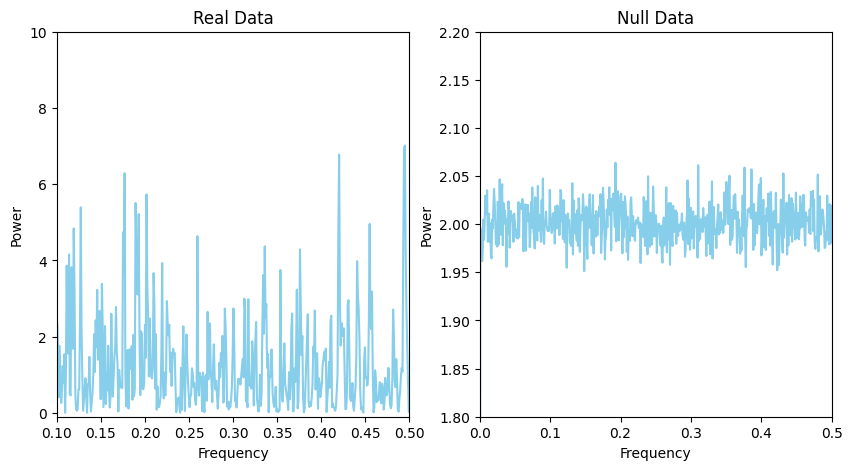

In [26]:
freq, power = periodogram(timeseries_cut, fs=1.0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs = axs.flatten()
axs[0].plot(freq, power, color="skyblue")
axs[0].set_title("Real Data")
axs[0].set_xlabel("Frequency")
axs[0].set_ylabel("Power")

axs[0].set_xlim(0.1, 0.5)
axs[0].set_ylim(-0.1, 10)

axs[1].plot(freq, null_data_av, color="skyblue")
axs[1].set_title("Null Data")
axs[1].set_xlabel("Frequency")
axs[1].set_ylabel("Power")

axs[1].set_xlim(0, 0.5)
axs[1].set_ylim(1.8, 2.2)

plt.show()

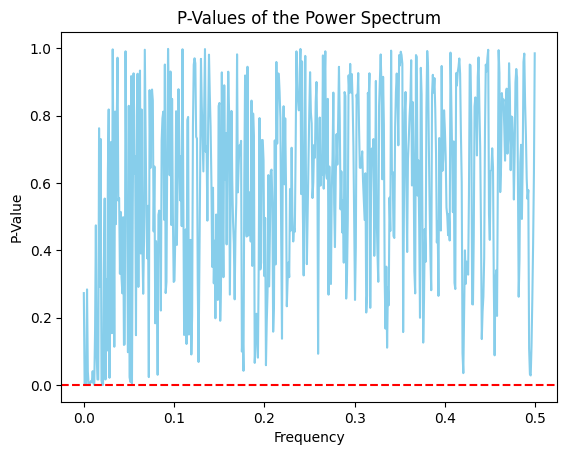

In [27]:
# we're going to use another formula, p val = sum(simulated power > observed power) / comparisons

p_vals = np.zeros(power.shape)

for i in range(power.shape[0]):
    result = np.sum(null_data[:, i] > power[i]) / nboot
    p_vals[i] = result

plot = sns.lineplot(x=freq, y=p_vals, color="skyblue")

plot.set_title("P-Values of the Power Spectrum")
plot.set_xlabel("Frequency")
plot.set_ylabel("P-Value")

plot.axhline(0.05 / len(p_vals), color="red", linestyle="--")

In [28]:
# sig_indices = np.where(p_vals < (0.05 / len(p_vals)))[0]
sig_indices = np.where((p_vals < (0.05 / len(p_vals))) & (p_vals != 1e-11))[0]
sig_indices = sig_indices[:10]

sig_p_vals = p_vals[sig_indices]
sig_freqs = freq[sig_indices]

(1 / sig_freqs) / 356, power[sig_indices], p_vals[np.argsort(p_vals)[:10]], sig_freqs


(array([3.16011236, 1.58005618, 0.45144462, 0.24308557]),
 array([123.84953758,  58.79310144,  21.34649507,  24.59753686]),
 array([0.    , 0.    , 0.    , 0.    , 0.0001, 0.0002, 0.0003, 0.0011,
        0.0016, 0.0058]),
 array([0.00088889, 0.00177778, 0.00622222, 0.01155556]))

In [29]:
countries_data = global_sales_concat["sales_territory_region"].unique().tolist()
boot = 10000
sigificant_frequencies_table = pd.DataFrame(columns=["Frequency", "Power", "Country"])

for i in range(len(countries_data)):
    sales_slice = global_sales_concat[
        global_sales_concat["sales_territory_region"] == countries_data[i]
    ]
    sales_slice = (
        sales_slice.groupby(sales_slice["standard_order_date"])["line_margin"]
        .sum()
        .reset_index()
    )
    # sales_slice = sales_slice.set_index("standard_order_date").resample("D").asfreq()
    # sales_slice = sales_slice.interpolate(method='linear')
    timeseries_cut = sales_slice["line_margin"].values

    freq, power = periodogram(timeseries_cut, fs=1.0)

    # Standardise timeseries
    timeseries_cut = (timeseries_cut - np.mean(timeseries_cut)) / np.std(timeseries_cut)

    null_data = bootstrap(timeseries_cut, nboot, manual_fft)
    null_data_av = np.mean(null_data, axis=0)
    null_data

    # Generate P values
    p_vals = np.zeros(power.shape)

    for j in range(power.shape[0]):
        result = np.sum(null_data[:, j] > power[j]) / nboot

        if result == 0:
            continue
        p_vals[j] = result

    sig_indices = np.where((p_vals < (0.05 / len(p_vals))) & (p_vals != 1e-11))[0]
    sig_indices = sig_indices[:5]

    sig_freqs = freq[sig_indices]
    print(sig_freqs)
    sig_freqs = np.round((1 / sig_freqs) / 356, 2)

    new_rows = pd.DataFrame(
        {
            "Frequency": sig_freqs,
            "Power": power[sig_indices],
            "Country": countries_data[i],
        }
    )

    sigificant_frequencies_table = pd.concat([sigificant_frequencies_table, new_rows])

sigificant_frequencies_table.replace([np.inf, -np.inf], np.nan, inplace=True)
sigificant_frequencies_table.dropna(inplace=True)

[0.         0.00096339 0.00192678 0.00289017 0.00385356]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\846726454.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)
C:\Users\janus\AppData\Local\Temp\ipykernel_16744\846726454.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sigificant_frequencies_table = pd.concat([sigificant_frequencies_table, new_rows])


[0.         0.00162338 0.00324675 0.00487013 0.00649351]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\846726454.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)


[0.         0.00141643 0.00283286 0.00424929 0.00566572]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\846726454.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)


[0.         0.00137931 0.00275862 0.00413793 0.00551724]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\846726454.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)


[0.         0.00130208 0.00260417 0.00390625 0.00520833]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\846726454.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)


[0.         0.00098619 0.00197239 0.00295858 0.00394477]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\846726454.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)


Text(0, 0.5, 'Power Scaled')

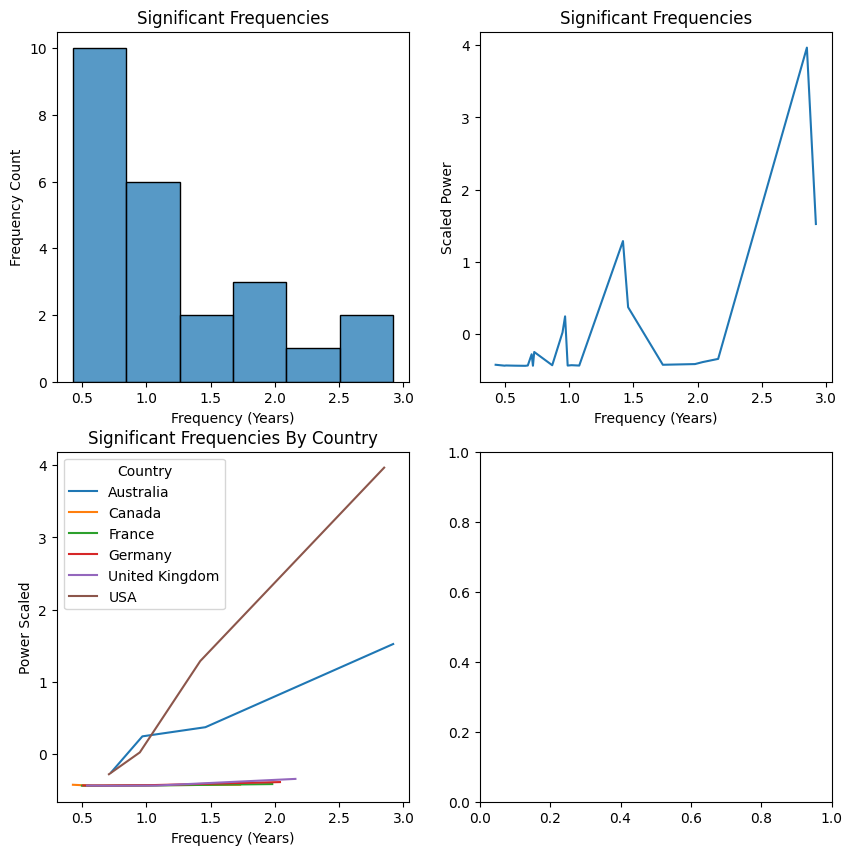

In [30]:
sigificant_frequencies_table["Power Scaled"] = (
    sigificant_frequencies_table["Power"] - sigificant_frequencies_table["Power"].mean()
) / sigificant_frequencies_table["Power"].std()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

sns.histplot(sigificant_frequencies_table, x="Frequency", ax=axs[0])
axs[0].set_title("Significant Frequencies")
axs[0].set_xlabel("Frequency (Years)")
axs[0].set_ylabel("Frequency Count")

sns.lineplot(
    x="Frequency", y="Power Scaled", data=sigificant_frequencies_table, ax=axs[1]
)
axs[1].set_title("Significant Frequencies")
axs[1].set_xlabel("Frequency (Years)")
axs[1].set_ylabel("Scaled Power")

sns.lineplot(
    sigificant_frequencies_table,
    x="Frequency",
    y="Power Scaled",
    hue="Country",
    ax=axs[2],
)
axs[2].set_title("Significant Frequencies By Country")
axs[2].set_xlabel("Frequency (Years)")
axs[2].set_ylabel("Power Scaled")

# This shows, that despite intial observation, there are annual, bianual, and 18 month/1.5 year periodicities
## I would rule out 2 and 3 years as the data is rougly 4 years long, so we can't concretely conclude this is a frequency will repeat more than once as it is more than half the time lenght

In [31]:
# # Is this impacted by product category? Here we will concatenate all the data for simplicity over granualarity

subcategory_data = ["road bikes", "mountain bikes", "touring bikes"]
boot = 10000
sigificant_frequencies_table = pd.DataFrame(
    columns=["Frequency", "Power", "Subcategory"]
)

for i in range(len(subcategory_data)):
    sales_slice = global_sales_concat[
        global_sales_concat["product_subcategory"] == subcategory_data[i]
    ]
    sales_slice = (
        sales_slice.groupby(sales_slice["standard_order_date"])["line_margin"]
        .sum()
        .reset_index()
    )
    timeseries_cut = sales_slice["line_margin"].values

    freq, power = periodogram(timeseries_cut, fs=1.0)

    # Standardise timeseries
    timeseries_cut = (timeseries_cut - np.mean(timeseries_cut)) / np.std(timeseries_cut)

    null_data = bootstrap(timeseries_cut, nboot, manual_fft)
    null_data_av = np.mean(null_data, axis=0)
    null_data

    # Generate P values
    p_vals = np.zeros(power.shape)

    for j in range(power.shape[0]):
        result = np.sum(null_data[:, j] > power[j]) / nboot

        if result == 0:
            continue
        p_vals[j] = result

    sig_indices = np.where((p_vals < (0.05 / len(p_vals))) & (p_vals != 1e-11))[0]
    sig_indices = sig_indices[:5]

    sig_freqs = freq[sig_indices]
    print(sig_freqs)
    sig_freqs = np.round((1 / sig_freqs) / 356, 2)

    new_rows = pd.DataFrame(
        {
            "Frequency": sig_freqs,
            "Power": power[sig_indices],
            "Subcategory": subcategory_data[i],
        }
    )

    sigificant_frequencies_table = pd.concat([sigificant_frequencies_table, new_rows])

sigificant_frequencies_table.replace([np.inf, -np.inf], np.nan, inplace=True)
sigificant_frequencies_table.dropna(inplace=True)

[0.         0.00093633 0.00187266 0.00280899 0.00374532]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\2219737173.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)
C:\Users\janus\AppData\Local\Temp\ipykernel_16744\2219737173.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sigificant_frequencies_table = pd.concat([sigificant_frequencies_table, new_rows])


[0.         0.00110619 0.00221239 0.00331858 0.00442478]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\2219737173.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)


[0.         0.0027933  0.00558659 0.00837989 0.01117318]


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\2219737173.py:37: RuntimeWarning: divide by zero encountered in divide
  sig_freqs = np.round((1/sig_freqs)/356,2)


C:\Users\janus\AppData\Local\Temp\ipykernel_16744\1599380405.py:1: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(sigificant_frequencies_table, x="Frequency",y = 0, hue="Subcategory",


[]

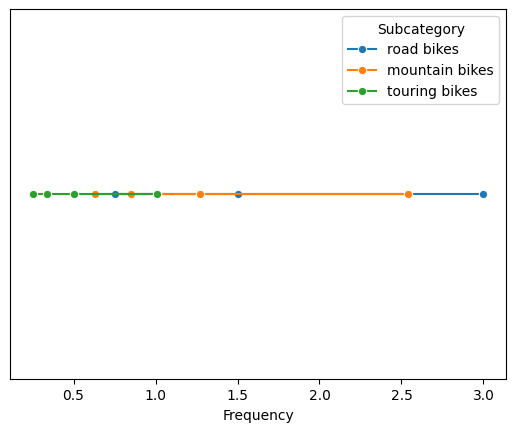

In [32]:
plot = sns.lineplot(
    sigificant_frequencies_table,
    x="Frequency",
    y=0,
    hue="Subcategory",
    markers="o",
    style="Subcategory",
    dashes=False,
)
plot.set_yticks([])
# Mountain bikes live a little longer, their sales cycle is longer

In [33]:
sigificant_frequencies_table

,Frequency,Power,Subcategory
1,3.00,3.484471e+09,road bikes
2,1.50,4.022161e+08,road bikes
3,1.00,5.518025e+08,road bikes
4,0.75,1.755871e+06,road bikes
1,2.54,1.144917e+10,mountain bikes
2,1.27,2.637350e+09,mountain bikes
3,0.85,8.933074e+08,mountain bikes
4,0.63,5.438642e+08,mountain bikes
1,1.01,1.327910e+09,touring bikes
2,0.50,2.337627e+08,touring bikes


In [34]:
sigificant_frequencies_table

,Frequency,Power,Subcategory
1,3.00,3.484471e+09,road bikes
2,1.50,4.022161e+08,road bikes
3,1.00,5.518025e+08,road bikes
4,0.75,1.755871e+06,road bikes
1,2.54,1.144917e+10,mountain bikes
2,1.27,2.637350e+09,mountain bikes
3,0.85,8.933074e+08,mountain bikes
4,0.63,5.438642e+08,mountain bikes
1,1.01,1.327910e+09,touring bikes
2,0.50,2.337627e+08,touring bikes


# Seperate trends and seasonality, Janushan

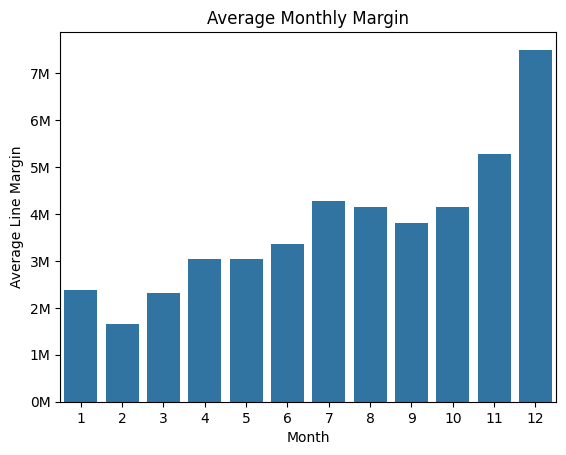

In [35]:
filt_data = global_sales[global_sales["Year"] < 2022]
filt_data = filt_data[
    filt_data["sales_territory_region"].isin(
        ["Central", "Northwest", "Southwest", "Southeast", "Northeast"]
    )
]
subproducts = ["road bikes", "mountain bikes", "touring bikes"]
filt_data = filt_data[filt_data["product_subcategory"].isin(subproducts)]

average_monthly_sales = (
    filt_data.groupby(filt_data["standard_order_date"].dt.month)["line_margin"]
    .sum()
    .reset_index()
)
# average_monthly_sales
plot = sns.barplot(data=average_monthly_sales, x="standard_order_date", y="line_margin")
plot.set_xlabel("Month")
plot.set_ylabel("Average Line Margin")
plot.set_title("Average Monthly Margin")
plot.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x / 1e5:.0f}M"))

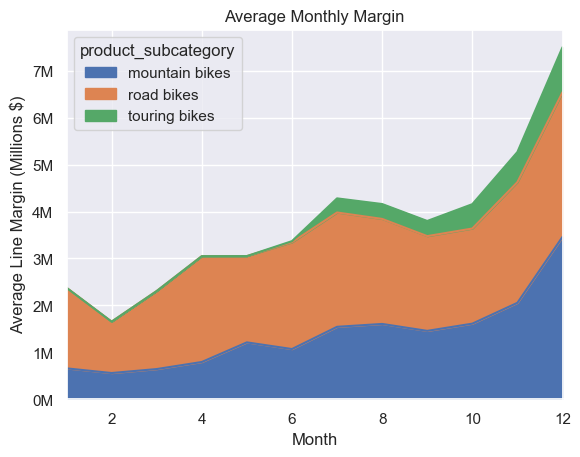

In [36]:
# Can we make this an area plot, to show the distribution of the margin over the months, by product subcategory

filt_data = global_sales[global_sales["Year"] < 2022]
filt_data = filt_data[
    filt_data["sales_territory_region"].isin(
        ["Central", "Northwest", "Southwest", "Southeast", "Northeast"]
    )
]
subproducts = ["road bikes", "mountain bikes", "touring bikes"]
filt_data = filt_data[filt_data["product_subcategory"].isin(subproducts)]

average_monthly_sales = filt_data.groupby(
    [filt_data["standard_order_date"].dt.month, "product_subcategory"]
)["line_margin"].sum()

sns.set_theme(style="darkgrid")
plot = average_monthly_sales.unstack().plot(kind="area", stacked=True)

plot.set_xlabel("Month")
plot.set_ylabel("Average Line Margin (Millions $)")
plot.set_title("Average Monthly Margin")
plot.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x / 1e5:.0f}M"))

plot.margins(0)

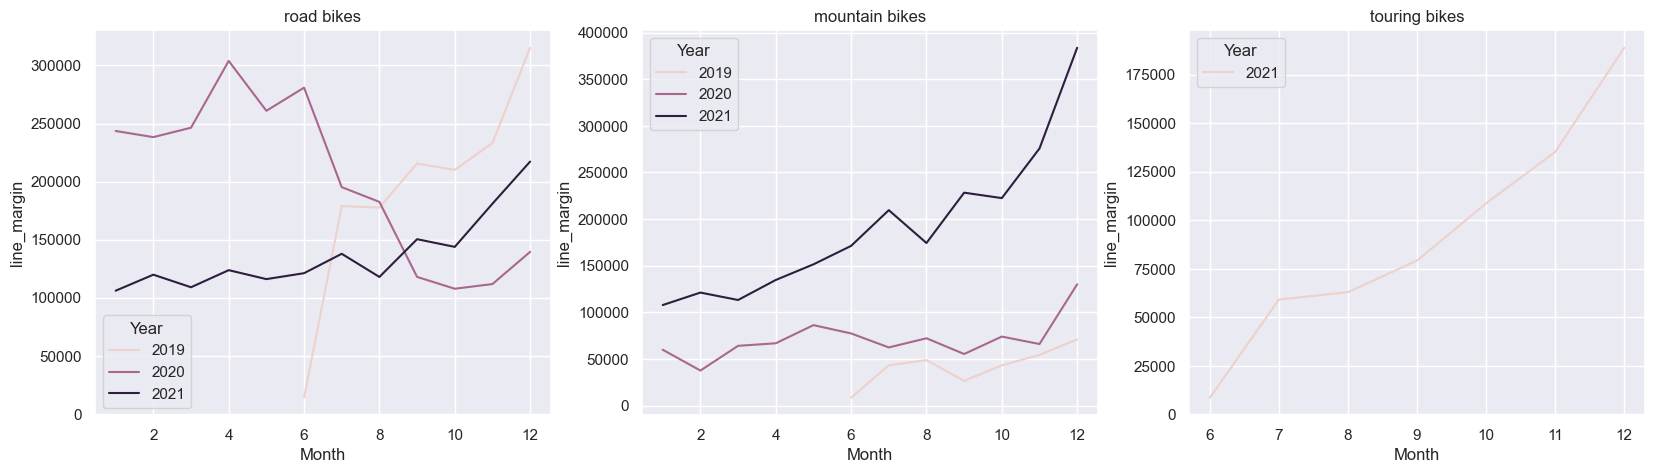

In [37]:
## Seasonality of top products

filt_data = global_sales[global_sales["Year"] != 2022]
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
subproducts = ["road bikes", "mountain bikes", "touring bikes"]

for i in subproducts:
    subproduct_sales = filt_data[filt_data["product_subcategory"] == i]
    timeseries = (
        subproduct_sales.groupby(["Year", "Month"])["line_margin"].sum().reset_index()
    )
    # timeseries.unstack().plot(x="Month", y="line_margin" ,ax=axs[subproducts.index(i)], title = i)
    # sns.lineplot(x="Month", y="line_margin", data=timeseries,hue="Year")
    sns.lineplot(
        data=timeseries,
        x="Month",
        y="line_margin",
        hue="Year",
        ax=axs[subproducts.index(i)],
    )
    axs[subproducts.index(i)].set_title(i)


<Axes: xlabel='Month', ylabel='line_margin'>

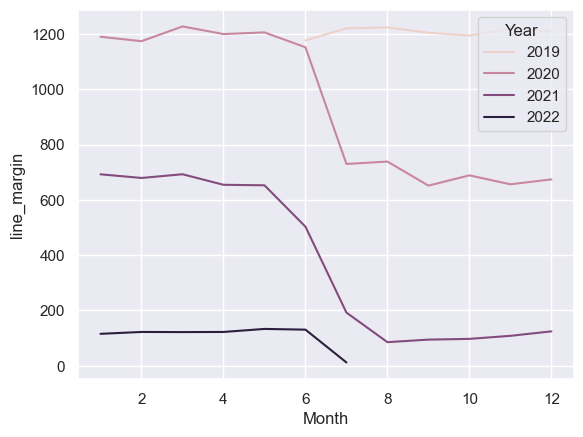

In [38]:
# yearly_timeseries = global_sales.groupby([global_sales['standard_order_date'].dt.to_period('M'),"Year"])[["line_margin"]].mean().reset_index()
# yearly_timeseries["standard_order_date"] = yearly_timeseries["standard_order_date"].dt.start_time


yearly_timeseries = (
    global_sales.groupby(["Month", "Year"])[["line_margin"]].mean().reset_index()
)
sns.lineplot(x="Month", y="line_margin", data=yearly_timeseries, hue="Year")


# max, min point, make dates horizontal, make it nicer to look at, price on y axis should have comma and doller sign

<Axes: xlabel='Quarter', ylabel='line_margin'>

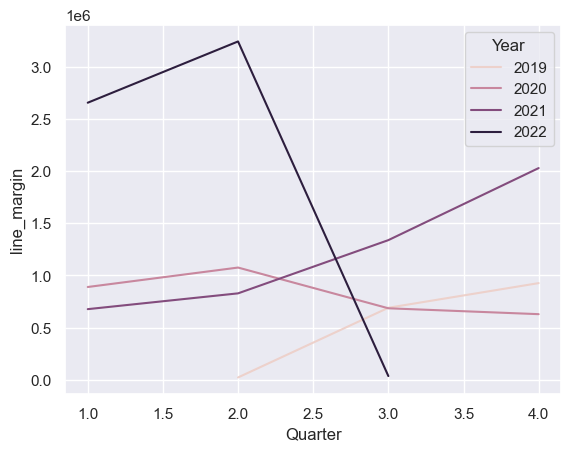

In [39]:
yearly_timeseries = (
    global_sales.groupby(["Quarter", "Year"])[["line_margin"]].sum().reset_index()
)
sns.lineplot(x="Quarter", y="line_margin", data=yearly_timeseries, hue="Year")

In [40]:
## What makes up the margin and cost of the top 3 products subcategories?

subproducts = ["road bikes", "mountain bikes", "touring bikes"]
subproduct_sales = global_sales[global_sales["product_subcategory"].isin(subproducts)]
subproduct_sales = (
    subproduct_sales.groupby(["product_name", "product_subcategory"])[["line_margin"]]
    .sum()
    .unstack(fill_value=1)
)
subproduct_sales

road_bikes_sales = global_sales[global_sales["product_subcategory"] == "road bikes"]
road_bikes_sales = road_bikes_sales.groupby(["product_name"])[
    ["line_margin", "cost_of_product"]
].sum()
road_bikes_sales[scale_columns] = round(
    road_bikes_sales[scale_columns].div(road_bikes_sales[scale_columns].sum(), axis=1)
    * 100,
    1,
)
road_bikes_sales = road_bikes_sales.sort_values(by="line_margin", ascending=False).head(
    5
)

mountain_bikes_sales = global_sales[
    global_sales["product_subcategory"] == "mountain bikes"
]
mountain_bikes_sales = mountain_bikes_sales.groupby(["product_name"])[
    ["line_margin", "cost_of_product"]
].sum()
mountain_bikes_sales[scale_columns] = round(
    mountain_bikes_sales[scale_columns].div(
        mountain_bikes_sales[scale_columns].sum(), axis=1
    )
    * 100,
    1,
)
mountain_bikes_sales = mountain_bikes_sales.sort_values(
    by="line_margin", ascending=False
).head(5)

touring_bikes_sales = global_sales[
    global_sales["product_subcategory"] == "touring bikes"
]
touring_bikes_sales = touring_bikes_sales.groupby(["product_name"])[
    ["line_margin", "cost_of_product"]
].sum()
touring_bikes_sales[scale_columns] = round(
    touring_bikes_sales[scale_columns].div(
        touring_bikes_sales[scale_columns].sum(), axis=1
    )
    * 100,
    1,
)
touring_bikes_sales = touring_bikes_sales.sort_values(
    by="line_margin", ascending=False
).head(5)

road_bikes_sales, mountain_bikes_sales, touring_bikes_sales


(                  line_margin  cost_of_product
 product_name                                  
 Road-150 Red, 48          8.9              8.3
 Road-150 Red, 62          8.7              8.1
 Road-150 Red, 52          7.8              7.3
 Road-150 Red, 56          7.5              7.0
 Road-150 Red, 44          7.2              6.7,
                          line_margin  cost_of_product
 product_name                                         
 Mountain-200 Black, 46          14.4             14.2
 Mountain-200 Black, 42          13.8             13.6
 Mountain-200 Silver, 38         13.5             13.5
 Mountain-200 Silver, 46         13.3             13.3
 Mountain-200 Black, 38          13.3             13.1,
                          line_margin  cost_of_product
 product_name                                         
 Touring-1000 Blue, 46           11.1             11.1
 Touring-1000 Yellow, 46         10.6             10.7
 Touring-1000 Yellow, 54         10.4             10.4
 T

# OOP, making the analysis more modular

In [20]:
# Import functions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


class DataInfo:

    def __init__(self, df: pd.DataFrame):
        self.df = df

    def get_top_prods(self, df, n: int = 5) -> pd.DataFrame:
        """Returns top n subcategories based on line margin.
        Returns: pd.dataframe."""

        dat = df.groupby(df["product_subcategory"])[["line_margin"]].sum()
        return dat.sort_values(by="line_margin", ascending=False).head(n)

    def products_monthly_sales(self, df: pd.DataFrame) -> pd.DataFrame:
        """returns average monthly performance of the subproducts."""

        return df.groupby([df["standard_order_date"].dt.month, "product_subcategory"])[
            "line_margin"
        ].sum()

    def plot_top_prods(self, n: int = 5):
        """Plots the top n subcategories based on line margin.
        Parameters: no. subproducts ..
        Returns: Horizontal barplot of line margin."""

        df = self.get_top_prods(n)
        
        plot = sns.barplot(
            y="product_subcategory", x="line_margin", data=df, orient="h"
        )
        plot.xaxis.set_major_formatter(
            mticker.FuncFormatter(lambda x, _: f"{x / 1e6:.0f}M")
        )

        plt.xlabel("Margin (Millions $)")
        plt.ylabel("Product Subcategory")
        plt.show()

    def plot_top_prods_monthly(
        self,
        n: int = 5,
        locs: list | str = [
            "Central",
            "Northwest",
            "Southwest",
            "Southeast",
            "Northeast",
        ],
        start: int = None,
        end: int = None,
    ):
        """ Returns area plot of line margin for the n subcategories.
        Parameters: n, the number of subproducts, list of locations, start and end year.
        Returns: Area plot of the top n products."""
        
        filtered_self = self.df

        if start and end:
            filtered_self = Filter.date(start, end, filtered_self).df
        
        filtered_self = Filter.location(locs, filtered_self).df
        filtered_self = Filter.product(self.get_top_prods(filtered_self, n).index.tolist(), filtered_self).df
        filtered_self = self.products_monthly_sales(filtered_self)

        sns.set_theme(style="darkgrid")
        plot = filtered_self.unstack().plot(kind="area", stacked=True)

        plot.set_xlabel("Month")
        plot.set_ylabel("Average Line Margin (Millions $)")
        plot.set_title("Average Monthly Margin")
        plot.yaxis.set_major_formatter(
            mticker.FuncFormatter(lambda x, _: f"{x / 1e5:.0f}M")
        )

        plot.margins(0)
        
        
        

In [14]:
class Filter:
    
    @staticmethod
    def date(start: int, end: int, df) -> pd.DataFrame:
        """Parameters: start year - int, end year - int."""
        df = df.loc[(df["Year"] >= start) & (df["Year"] <= end)]
        return DataInfo(df)
    
    @staticmethod
    def location(locs: list | str, df) -> pd.DataFrame:
        """Parameters: list of locations.
        Returns: filtered pandas PD dataframe"""

        if isinstance(locs, list):
            df = df.loc[df["sales_territory_region"].isin(locs)]
            return DataInfo(df)
        else:
            df = df.loc[df["sales_territory_region"] == locs]
            return DataInfo(df)
    
    @staticmethod
    def product(prods: list | str, df) -> pd.DataFrame:
        """Parameters: list of products.
        Returns: filtered pandas PD dataframe"""

        if isinstance(prods,list):
            df =  df.loc[df["product_subcategory"].isin(prods)]
            return DataInfo(df)
        else:
            df = df.loc[df["product_subcategory"] == prods]
            return DataInfo(df)

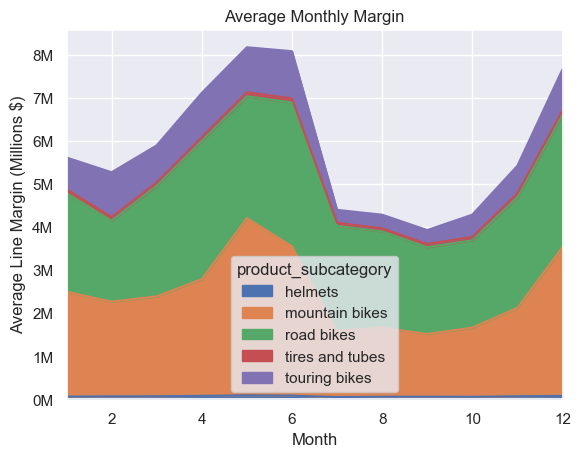

In [22]:
x = DataInfo(global_sales)

# y = Filter.date(start = 2019,
#                        end = 2021,
#                        df = x.df)

# z = Filter.location(locs = "Central",
#                     df = y.df)

# h = Filter.product(prods = "mountain bikes",
#                    df = z.df)

x.plot_top_prods_monthly(n = 5,
                         # start = 2019,
                         # end = 2022
                         )


# Pytest, SOLID OOP, rest API, Java